In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from statistics import mean, stdev
from sklearn.preprocessing import scale 
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import json
import urllib.parse
import requests
import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel

In [4]:
train = pd.read_csv("train_2016_v2.csv")   #The parcelid's with their outcomes
props = pd.read_csv("properties_2016.csv")  #The properties dataset
samp = pd.read_csv("sample_submission.csv")
train_imp_feats = pd.read_csv("train_imp_feats.csv")   #The parcelid's with their outcomes
train_eng_feats = pd.read_csv("train_eng_feats.csv")  #The properties dataset


In [5]:
train['month'] = pd.DatetimeIndex(train['transactiondate']).month
train['transactiondate'] = pd.to_datetime(train['transactiondate'])
train['day'] = train['transactiondate'].dt.day_name()
train.head()

,parcelid,logerror,transactiondate,month,day
0,11016594,0.0276,2016-01-01,1,Friday
1,14366692,-0.1684,2016-01-01,1,Friday
2,12098116,-0.0040,2016-01-01,1,Friday
3,12643413,0.0218,2016-01-02,1,Saturday
4,14432541,-0.0050,2016-01-02,1,Saturday


In [6]:
props = props.select_dtypes(exclude=[object])  #For this example, we take only numerical data, since strings require more processing
props.fillna(-1,inplace=True)  #Fill missing data so we can run the model
train = train.loc[:,['parcelid','logerror']].merge(props,how='left',left_on='parcelid',right_on='parcelid')
train_x = train.drop(['parcelid','logerror'],axis=1,inplace=False)
train_y = train['logerror']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
     train_x, train_y, test_size=0.2, random_state=42)

In [9]:
rf = RandomForestRegressor(n_estimators=2100,
                            max_features=6,
                            max_depth=11,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

feature_imp = pd.Series(rf.feature_importances_,index=train_x.columns).sort_values(ascending=False)
feature_imp

taxamount                       0.082258
taxvaluedollarcnt               0.073163
structuretaxvaluedollarcnt      0.069863
latitude                        0.066094
landtaxvaluedollarcnt           0.063636
calculatedfinishedsquarefeet    0.060720
lotsizesquarefeet               0.056450
longitude                       0.053975
finishedsquarefeet12            0.046647
regionidzip                     0.042224
yearbuilt                       0.041229
censustractandblock             0.035190
rawcensustractandblock          0.034270
regionidcity                    0.023356
bedroomcnt                      0.023329
regionidneighborhood            0.019322
bathroomcnt                     0.017138
calculatedbathnbr               0.016586
finishedsquarefeet15            0.015196
fullbathcnt                     0.014755
garagetotalsqft                 0.011807
buildingqualitytypeid           0.011467
propertylandusetypeid           0.011421
airconditioningtypeid           0.009510
finishedfloor1sq

In [10]:
target_pred=rf.predict(X_test)
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))

MSE:    0.025774003941820566


In [12]:
sfm = SelectFromModel(rf, threshold=0.01)
# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2100, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.01)

In [13]:
feat_labels = train_x.columns.tolist()
imp_labels = []
count = 0
for feature_list_index in sfm.get_support(indices=True):
    imp_labels.append(feat_labels[feature_list_index])
    count+=1
    print(feat_labels[feature_list_index])
print(count)

bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedbathnbr
calculatedfinishedsquarefeet
finishedsquarefeet12
finishedsquarefeet15
fullbathcnt
garagetotalsqft
latitude
longitude
lotsizesquarefeet
propertylandusetypeid
rawcensustractandblock
regionidcity
regionidneighborhood
regionidzip
yearbuilt
structuretaxvaluedollarcnt
taxvaluedollarcnt
landtaxvaluedollarcnt
taxamount
censustractandblock
23


In [23]:
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators':[1500], 'max_depth': [16,17], 'max_features': [6], 'random_state': [42], 'n_jobs':[-1]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rf.set_params(**g)  # ** is "unpacking" the dictionary
    rf.fit(X_train[imp_labels], y_train)
    test_scores.append(rf.score(X_train[imp_labels], y_train))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.33368251149791195 {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1500, 'max_features': 6, 'max_depth': 17}


In [27]:
rf = RandomForestRegressor(n_estimators=1500,
                            max_features=6,
                            max_depth=17,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train[imp_labels], y_train)

feature_imp = pd.Series(rf.feature_importances_,index=imp_labels).sort_values(ascending=False)
print(feature_imp)
print()
print('------------------------------------')
print()
target_pred=rf.predict(X_test[imp_labels])
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))


taxamount                       0.089475
taxvaluedollarcnt               0.079662
structuretaxvaluedollarcnt      0.077544
latitude                        0.076317
lotsizesquarefeet               0.072962
landtaxvaluedollarcnt           0.071594
longitude                       0.070479
calculatedfinishedsquarefeet    0.068938
finishedsquarefeet12            0.054401
yearbuilt                       0.052707
regionidzip                     0.044601
censustractandblock             0.037987
rawcensustractandblock          0.037443
regionidneighborhood            0.024945
regionidcity                    0.024158
bedroomcnt                      0.023029
finishedsquarefeet15            0.015083
bathroomcnt                     0.013948
garagetotalsqft                 0.013921
calculatedbathnbr               0.013703
propertylandusetypeid           0.012764
buildingqualitytypeid           0.012485
fullbathcnt                     0.011856
dtype: float64

------------------------------------

MSE

In [40]:
train_x = train_imp_feats[train_imp_feats.columns.difference(['Unnamed: 0'])]

train_x = train_x.select_dtypes(include=[np.number])
X_train, X_test, y_train, y_test = train_test_split(
     train_x, train_y, test_size=0.2, random_state=42)


In [41]:
train_x.columns.tolist()

['airconditioningtypeid',
 'architecturalstyletypeid',
 'assessmentyear',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'censustractandblock',
 'decktypeid',
 'elevation',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet15',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'heatingorsystemtypeid',
 'landtaxvaluedollarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'month',
 'numberofstories',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'structuretaxvaluedollarcnt',
 'taxamount',
 'taxdelinquencyyear',
 'taxvaluedollarcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt']

In [43]:
rf = RandomForestRegressor(n_estimators=1600,
                            max_features=6,
                            max_depth=17,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

feature_imp = pd.Series(rf.feature_importances_,index=train_x.columns).sort_values(ascending=False)
target_pred=rf.predict(X_test)
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))

sfm = SelectFromModel(rf, threshold=0.01)
sfm.fit(X_train, y_train)

feat_labels = train_x.columns.tolist()
imp_labels = []
count = 0
for feature_list_index in sfm.get_support(indices=True):
    imp_labels.append(feat_labels[feature_list_index])
    count+=1
    print(feat_labels[feature_list_index])
print(count)

MSE:    0.025655498908503594
architecturalstyletypeid
basementsqft
bathroomcnt
bedroomcnt
buildingqualitytypeid
calculatedfinishedsquarefeet
censustractandblock
elevation
finishedfloor1squarefeet
finishedsquarefeet12
finishedsquarefeet15
garagetotalsqft
heatingorsystemtypeid
landtaxvaluedollarcnt
latitude
longitude
lotsizesquarefeet
month
poolsizesum
propertylandusetypeid
rawcensustractandblock
regionidcity
regionidneighborhood
regionidzip
structuretaxvaluedollarcnt
taxamount
taxdelinquencyyear
taxvaluedollarcnt
yardbuildingsqft17
yardbuildingsqft26
yearbuilt
31


In [45]:
grid = {'n_estimators':[1500], 'max_depth': [18,19], 'max_features': [6], 'random_state': [42], 'n_jobs':[-1]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rf.set_params(**g)  # ** is "unpacking" the dictionary
    rf.fit(X_train[imp_labels], y_train)
    test_scores.append(rf.score(X_train[imp_labels], y_train))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.36297400557487536 {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1500, 'max_features': 6, 'max_depth': 19}


In [48]:
rf = RandomForestRegressor(n_estimators=1500,
                            max_features=6,
                            max_depth=18,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train[imp_labels], y_train)

feature_imp = pd.Series(rf.feature_importances_,index=imp_labels).sort_values(ascending=False)
print(feature_imp)
print()
print('------------------------------------')
print()
target_pred=rf.predict(X_test[imp_labels])
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))



taxamount                       0.055335
calculatedfinishedsquarefeet    0.053134
lotsizesquarefeet               0.052235
structuretaxvaluedollarcnt      0.051348
finishedsquarefeet12            0.051289
taxvaluedollarcnt               0.049592
latitude                        0.045884
landtaxvaluedollarcnt           0.044664
longitude                       0.043199
finishedsquarefeet15            0.040464
elevation                       0.040144
regionidneighborhood            0.039665
yearbuilt                       0.037467
poolsizesum                     0.036950
finishedfloor1squarefeet        0.035995
regionidzip                     0.031173
garagetotalsqft                 0.029073
yardbuildingsqft17              0.027378
censustractandblock             0.025424
rawcensustractandblock          0.024041
basementsqft                    0.023696
month                           0.022147
yardbuildingsqft26              0.020932
regionidcity                    0.019033
bedroomcnt      

In [69]:
train_x = train_eng_feats[train_eng_feats.columns.difference(['Unnamed: 0','logerror'])]
train_y = train_eng_feats['logerror']
train_x = train_x.select_dtypes(include=[np.number])
X_train, X_test, y_train, y_test = train_test_split(
     train_x, train_y, test_size=0.2, random_state=42)

In [70]:
rf = RandomForestRegressor(n_estimators=1600,
                            max_features=6,
                            max_depth=17,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train, y_train)

feature_imp = pd.Series(rf.feature_importances_,index=train_x.columns).sort_values(ascending=False)
target_pred=rf.predict(X_test)
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))

sfm = SelectFromModel(rf, threshold=0.01)
sfm.fit(X_train, y_train)

feat_labels = train_x.columns.tolist()
imp_labels = []
count = 0
for feature_list_index in sfm.get_support(indices=True):
    imp_labels.append(feat_labels[feature_list_index])
    count+=1
    print(feat_labels[feature_list_index])
print(count)

MSE:    0.025667103287580425
basementsqft
calculatedfinishedsquarefeet
censustractandblock
elev_local_20
elev_local_5
elevation
finishedfloor1squarefeet
finishedsquarefeet12
finishedsquarefeet15
garagetotalsqft
landtaxvaluedollarcnt
latitude
longitude
lot_local_100
lot_local_20
lot_local_5
lotsizesquarefeet
month
poolsizesum
rawcensustractandblock
regionidcity
regionidneighborhood
regionidzip
sqft_local_100
sqft_local_20
sqft_local_5
structuretaxvaluedollarcnt
tax_local_100
tax_local_20
tax_local_5
taxamount
taxdelinquencyyear
taxvaluedollarcnt
yardbuildingsqft17
yardbuildingsqft26
year_local_100
year_local_20
year_local_5
yearbuilt
39


In [71]:
grid = {'n_estimators':[1500], 'max_depth': [18,19], 'max_features': [6], 'random_state': [42], 'n_jobs':[-1]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rf.set_params(**g)  # ** is "unpacking" the dictionary
    rf.fit(X_train[imp_labels], y_train)
    test_scores.append(rf.score(X_train[imp_labels], y_train))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.40120687485397677 {'random_state': 42, 'n_jobs': -1, 'n_estimators': 1500, 'max_features': 6, 'max_depth': 19}


In [73]:
rf = RandomForestRegressor(n_estimators=2500,
                            max_features=6,
                            max_depth=18,
                            n_jobs=-1,
                            random_state=42)

# Train the classifier
rf.fit(X_train[imp_labels], y_train)

feature_imp = pd.Series(rf.feature_importances_,index=imp_labels).sort_values(ascending=False)
print(feature_imp)
print()
print('------------------------------------')
print()
target_pred=rf.predict(X_test[imp_labels])
print("MSE:   ",metrics.mean_squared_error(y_test, target_pred))




structuretaxvaluedollarcnt      0.034941
latitude                        0.032810
taxvaluedollarcnt               0.032585
tax_local_5                     0.031528
taxamount                       0.031405
finishedsquarefeet12            0.031257
tax_local_20                    0.030587
lotsizesquarefeet               0.030578
finishedsquarefeet15            0.030529
lot_local_20                    0.030443
lot_local_5                     0.030427
sqft_local_5                    0.030416
tax_local_100                   0.030354
longitude                       0.030258
landtaxvaluedollarcnt           0.030139
sqft_local_20                   0.029955
sqft_local_100                  0.029881
calculatedfinishedsquarefeet    0.029791
lot_local_100                   0.029746
poolsizesum                     0.027707
regionidneighborhood            0.027124
finishedfloor1squarefeet        0.026539
regionidzip                     0.024258
elev_local_20                   0.023825
elev_local_5    

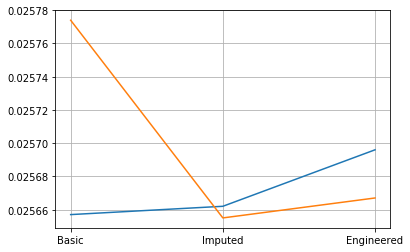

In [77]:
label = ['Basic','Imputed','Engineered']
value = [.025657,.025662,.025696]
value_all = [.025774,.025655,.025667]
plt.grid()
plt.plot(label,value)
plt.plot(label,value_all)
plt.show()

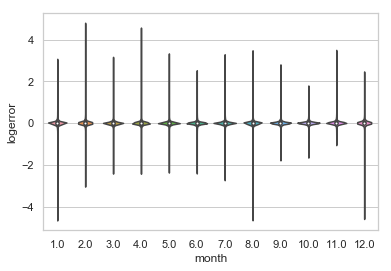

In [80]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x="month", y="logerror", data=train_eng_feats)


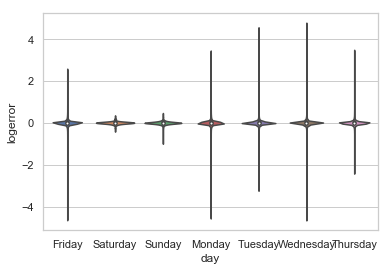

In [81]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x="day", y="logerror", data=train_eng_feats)



In [87]:
df = train_eng_feats.select_dtypes(exclude=np.number)

df.columns.tolist()

['day',
 'fireplaceflag',
 'hashottuborspa',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'taxdelinquencyflag']

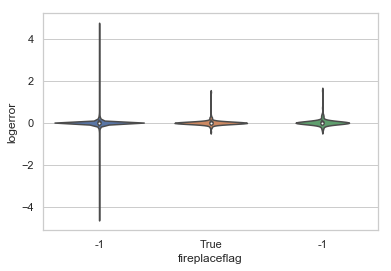

In [89]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x="fireplaceflag", y="logerror", data=train_eng_feats)

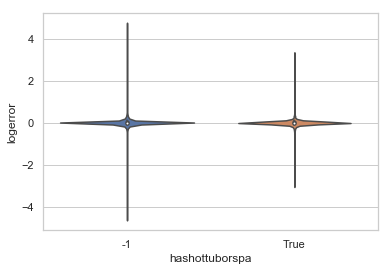

In [90]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(x="hashottuborspa", y="logerror", data=train_eng_feats)

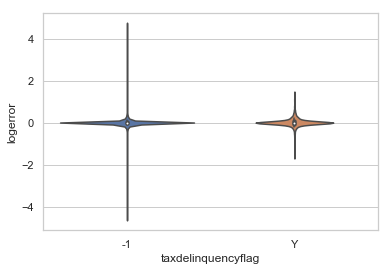

In [93]:
sns.set(style="whitegrid")
ax = sns.violinplot(x="taxdelinquencyflag", y="logerror", data=train_eng_feats)

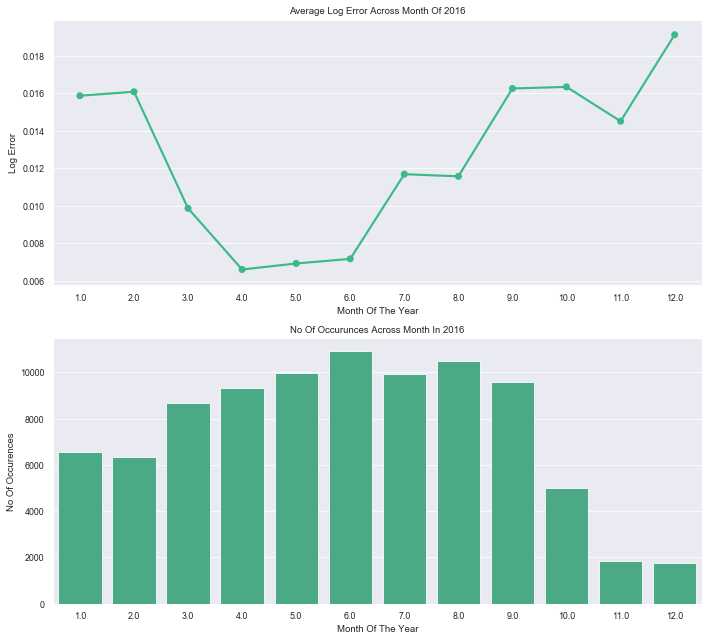

In [38]:
traingroupedMonth = train_eng_feats.groupby(["month"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train_eng_feats.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(10,9)


sns.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="#3bba89")
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')

sns.countplot(x=train_eng_feats["month"], data=train,ax=ax2,color="#3bba89")
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')
plt.tight_layout()

In [113]:
traingroupedMonth

,month,logerror
0,1.0,0.015870
1,2.0,0.016082
2,3.0,0.009867
3,4.0,0.006605
4,5.0,0.006926
5,6.0,0.007172
6,7.0,0.011687
7,8.0,0.011573
8,9.0,0.016255
9,10.0,0.016342


In [117]:
base = traingroupedMonth['logerror'][9]
nov = traingroupedMonth['logerror'][10]
dec = traingroupedMonth['logerror'][11]

fudge_nov = 1+(nov-base)/base
fudge_dec = 1+(dec-base)/base

print(fudge_nov, fudge_dec)

0.8879242828636326 1.1701592749545944


In [119]:
fudge_nov*base

0.014510131434830202

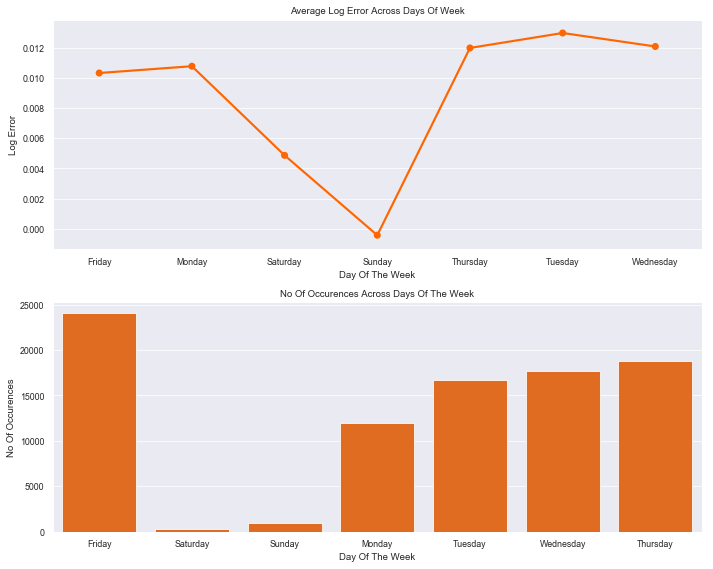

In [37]:


fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(10,8)

sns.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#ff6600")
ax1.set(xlabel='Day Of The Week', ylabel='Log Error',title="Average Log Error Across Days Of Week",label='big')

sns.countplot(x=train_eng_feats["day"], data=train_eng_feats,ax=ax2,color="#ff6600")
ax2.set(xlabel='Day Of The Week', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Week",label='big')
plt.tight_layout()

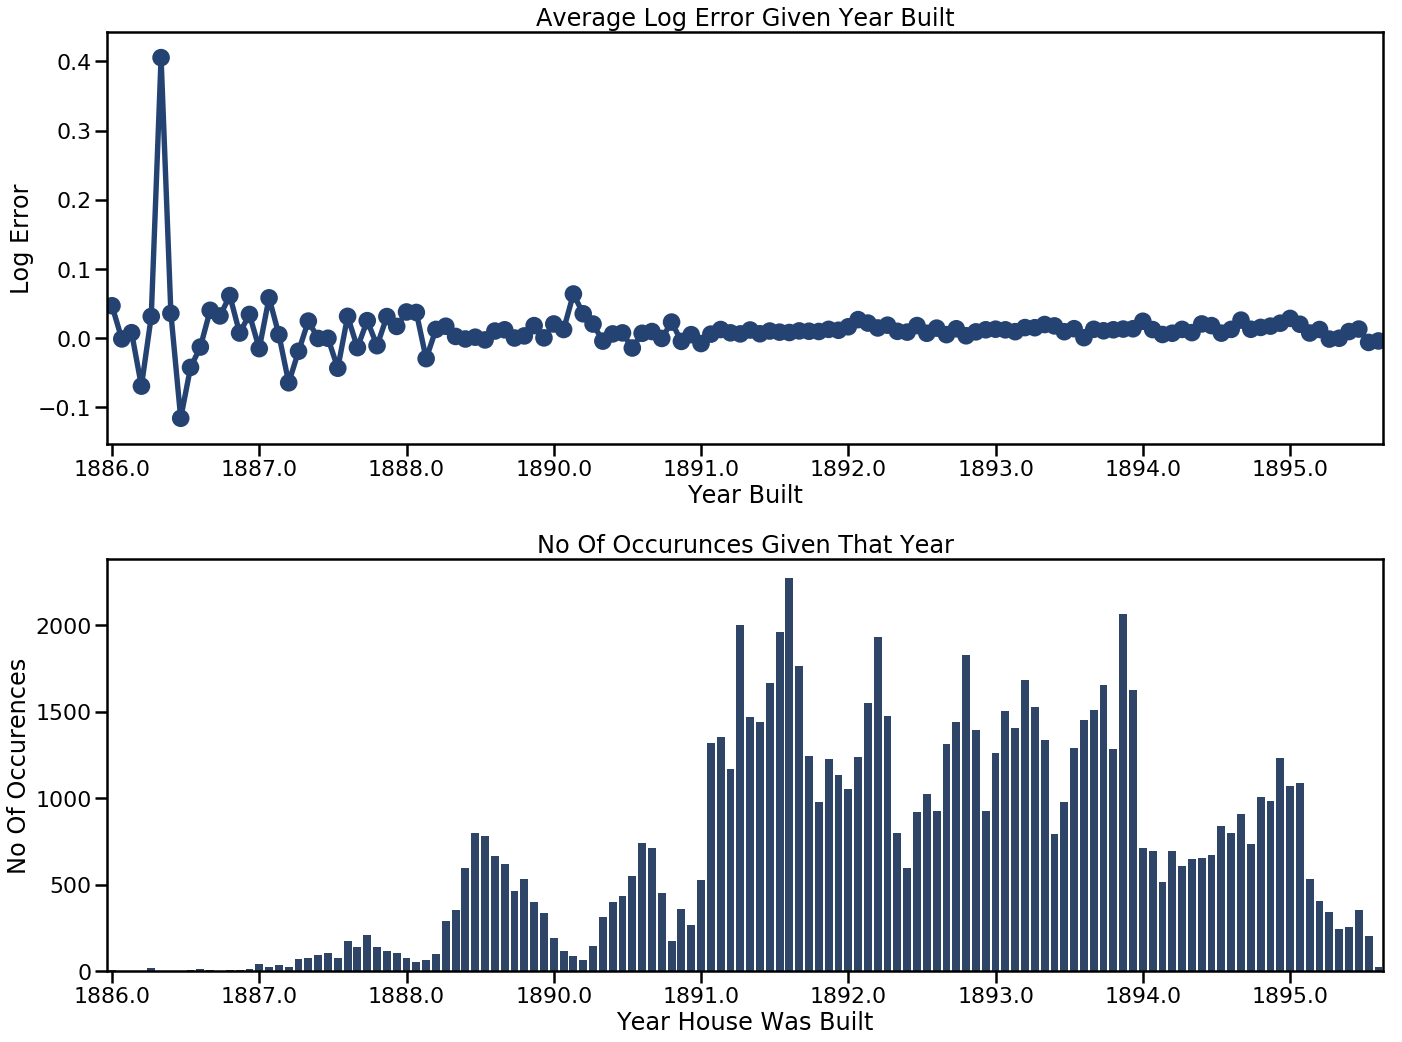

In [24]:

sns.set_context()
traingroupedMonth = train_eng_feats.groupby(["yearbuilt"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train_eng_feats.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)


sns.pointplot(x=traingroupedMonth["yearbuilt"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="#254372")
ax1.set(xlabel='Year Built', ylabel='Log Error',title="Average Log Error Given Year Built",label='big')
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))
sns.countplot(x=train_eng_feats["yearbuilt"], data=train,ax=ax2,color="#254372")
ax2.set(xlabel='Year House Was Built', ylabel='No Of Occurences',title="No Of Occurunces Given That Year",label='big')
ax2.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.tight_layout()

[Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 0, 'Day Of The Month'),
 Text(0.5, 1.0, 'No Of Occurences Across Days Of The Month In 2016'),
 None]

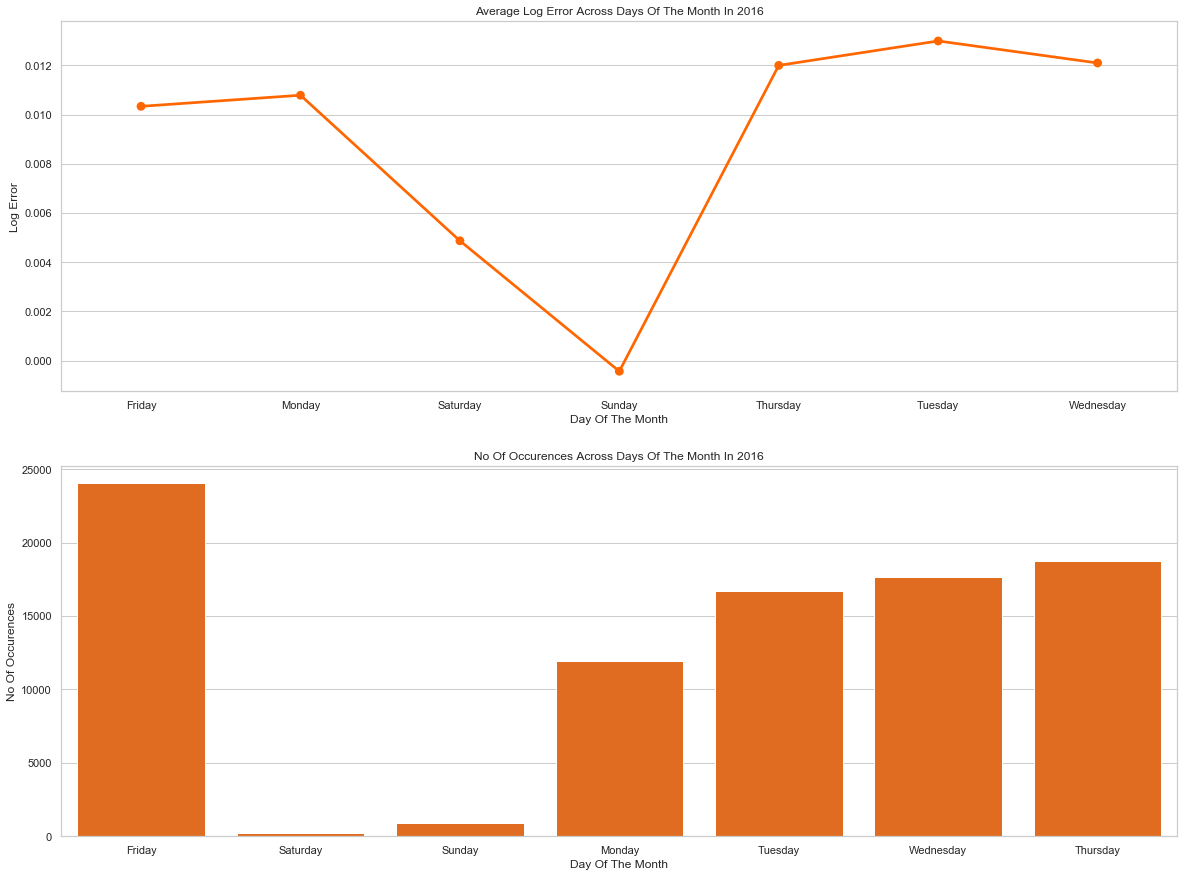

In [120]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sns.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#ff6600")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sns.countplot(x=train_eng_feats["day"], data=train_eng_feats,ax=ax2,color="#ff6600")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

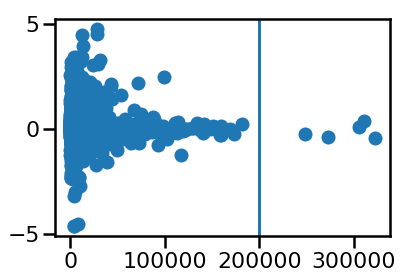

In [25]:
plt.scatter(train['taxamount'],train['logerror'])
plt.axvline(200000, 0,8)
plt.show()

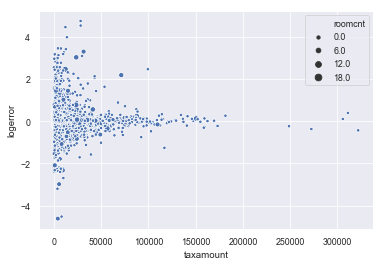

In [32]:
fig.set_size_inches(60,45)
sns.set()

sns.set_context("paper")
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="taxamount", y="logerror",
                      size="roomcnt",
                      palette="GnBu_d",
                      data=train_eng_feats)


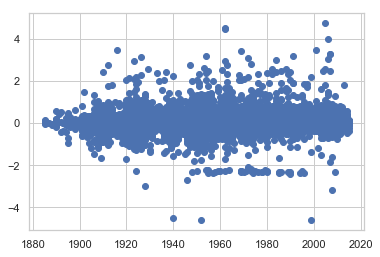

In [126]:
df = train[train['yearbuilt']>1000]
plt.scatter(df['yearbuilt'],df['logerror'])
#plt.axvline(, 0,8)
plt.show()

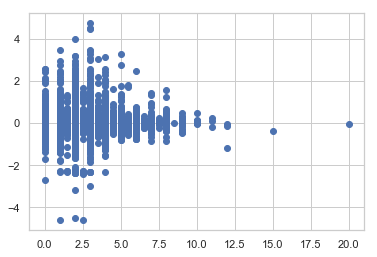

In [127]:

plt.scatter(train['bathroomcnt'],train['logerror'])
#plt.axvline(, 0,8)
plt.show()

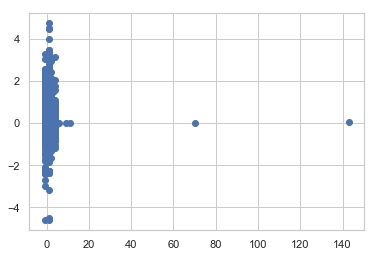

In [128]:
plt.scatter(train['unitcnt'],train['logerror'])
#plt.axvline(, 0,8)
plt.show()

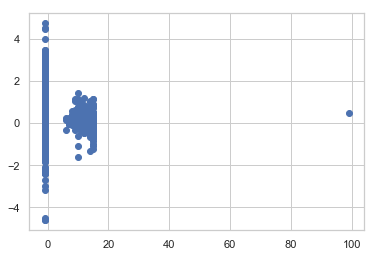

In [130]:
plt.scatter(train['taxdelinquencyyear'],train['logerror'])
#plt.axvline(, 0,8)
plt.show()

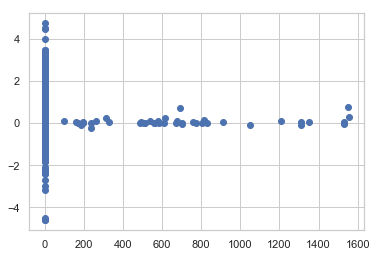

In [131]:
plt.scatter(train['basementsqft'],train['logerror'])
#plt.axvline(, 0,8)
plt.show()

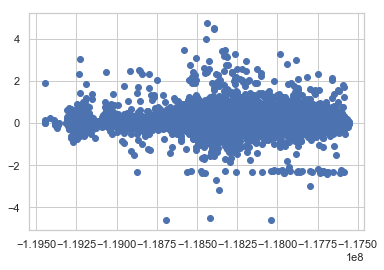

In [133]:
plt.scatter(train['longitude'],train['logerror'])
#plt.axvline(, 0,8)
plt.show()

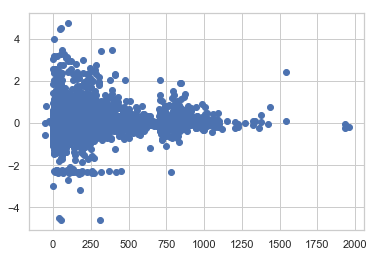

In [134]:
plt.scatter(train_eng_feats['elevation'],train_eng_feats['logerror'])
#plt.axvline(, 0,8)
plt.show()

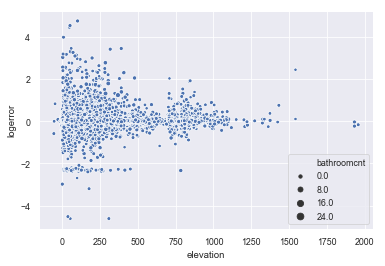

In [33]:
fig.set_size_inches(60,45)
sns.set()

sns.set_context("paper")
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="elevation", y="logerror",
                      size="bathroomcnt",
                      palette="GnBu_d",
                      data=train_eng_feats)



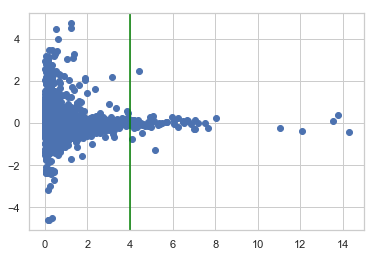

In [141]:
plt.scatter(train_eng_feats['tax_local_5'],train_eng_feats['logerror'])
plt.axvline(4, 0,8,color="green")
plt.show()